In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from classifier_selector import Classifier_selector
from sbs import SequentialBackwardSelection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from mpa import mpa
from sklearn.metrics import accuracy_score


In [2]:
''' Testing phase '''

' Testing phase '

In [3]:
classifier_selecting = Classifier_selector()

In [4]:
# Preprocessing

penguin_df = pd.read_csv("./Datasets/penguins.csv")
penguin_df.drop(columns = ["studyName", "Sample Number", "Region", "Island", "Stage", "Individual ID", "Clutch Completion", "Date Egg", "Sex", "Comments"], axis = 1,
                           inplace = True)

species = penguin_df.pop('Species')
penguin_df['Species'] = species
penguin_df = penguin_df.drop(penguin_df[penguin_df['Species']=='Gentoo penguin (Pygoscelis papua)'].index)

species_map = {'Adelie Penguin (Pygoscelis adeliae)':1, 'Chinstrap penguin (Pygoscelis antarctica)':0}
penguin_df.replace({"Species":species_map}, inplace = True)


def fill_nan_by_group(df, group_column, columns_to_fill=None):
    df_filled = df.copy()

    # If no columns specified, get all numeric columns except the group column
    if columns_to_fill is None:
        columns_to_fill = df.select_dtypes(include=[np.number]).columns
        columns_to_fill = columns_to_fill[columns_to_fill != group_column]

    # Fill each column separately
    for column in columns_to_fill:
        # Calculate means for each group for the current column
        group_means = df.groupby(group_column)[column].mean()

        # For each unique group, fill NaN values with that group's mean
        for group_value in df[group_column].unique():
            mask = (df[group_column] == group_value) & (df[column].isna())
            df_filled.loc[mask, column] = group_means[group_value]

    return df_filled
penguin_df = fill_nan_by_group(penguin_df, "Species")


train_df, test_df = train_test_split(penguin_df, test_size = 0.2)
X_train = train_df.drop("Species", axis = 1)
y_train = train_df["Species"]
X_test = test_df.drop("Species", axis = 1)
y_test = test_df["Species"]

/tmp/ipykernel_77138/1667827196.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  penguin_df.replace({"Species":species_map}, inplace = True)


In [5]:
penguin_df.isnull().sum()

Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Body Mass (g)          0
Delta 15 N (o/oo)      0
Delta 13 C (o/oo)      0
Species                0
dtype: int64

n_jobs = -1
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}

Best Cross-validation Score: 0.996078431372549

Feature Importances: None

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        28

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



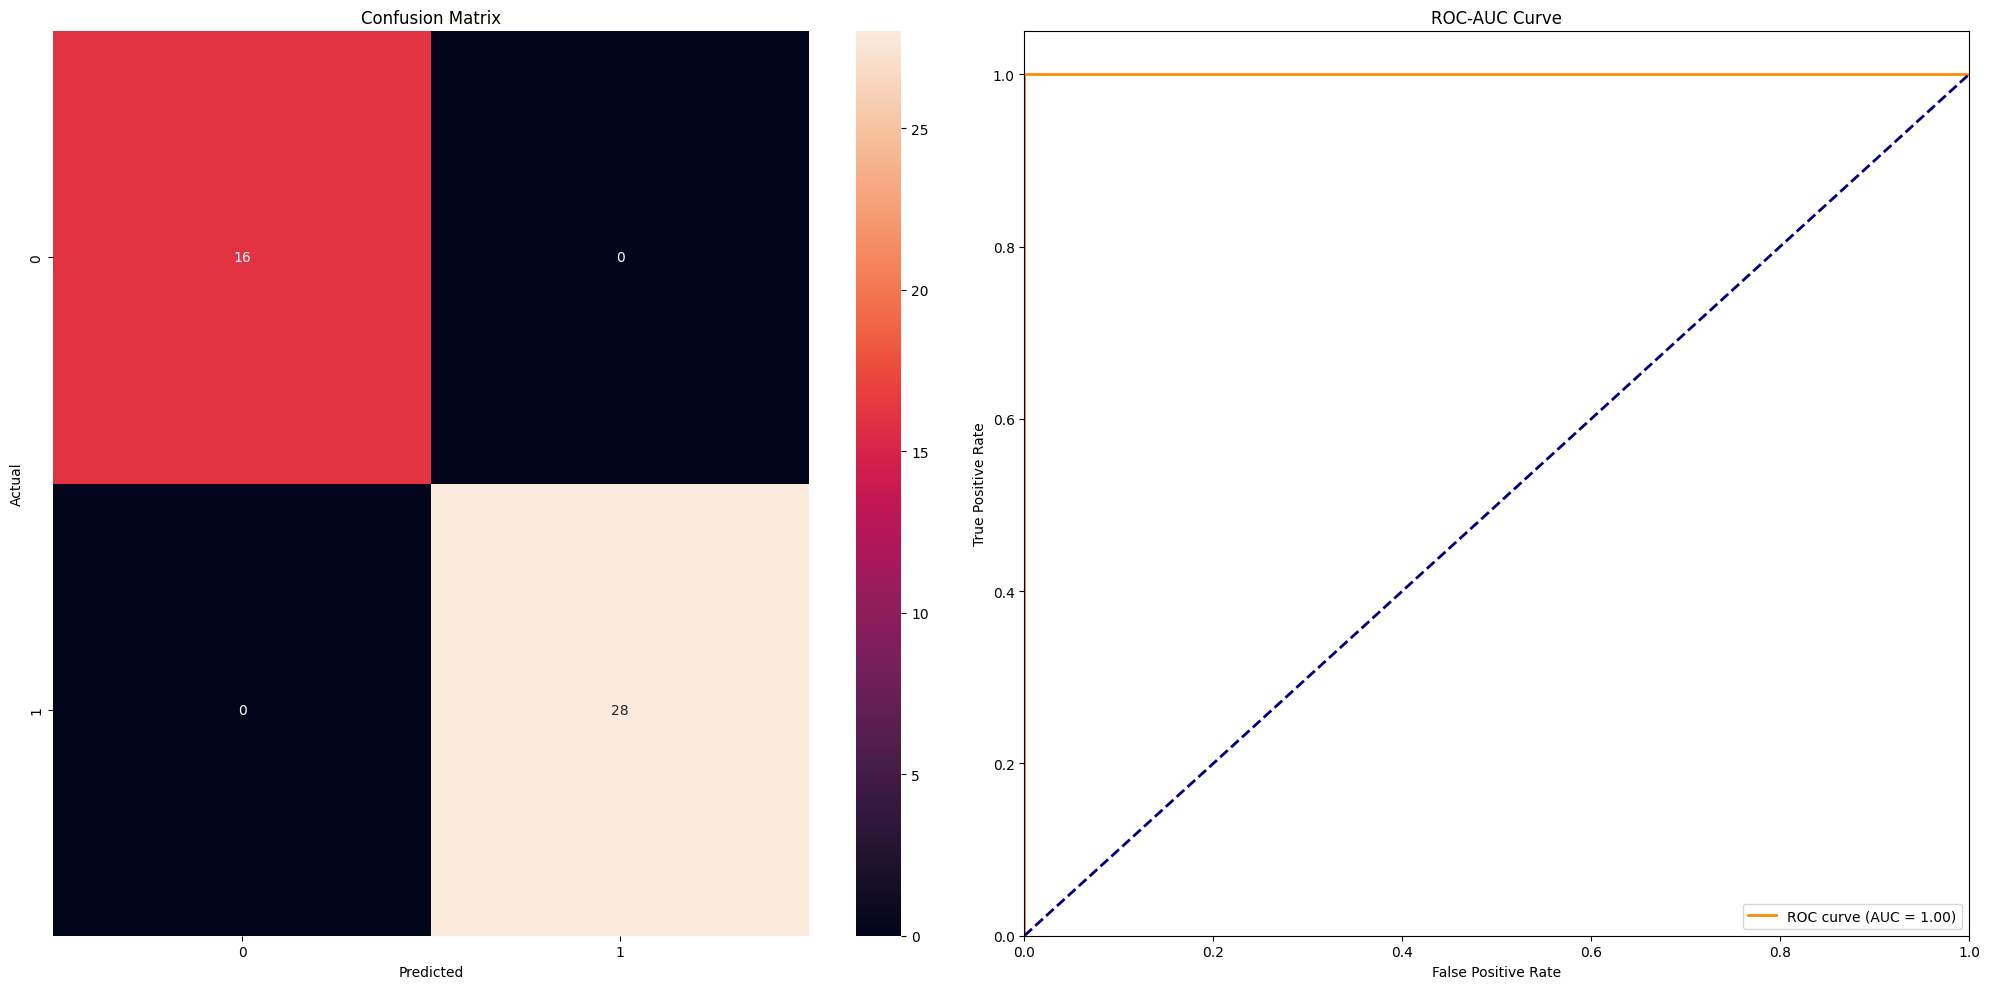

In [6]:
results_knn, scaler = classifier_selecting.optimize_classifier(X_train, X_test, y_train, y_test, 'knn')

print("\nBest Parameters:", results_knn['best_parameters'])
print("\nBest Cross-validation Score:", results_knn['best_score'])
print("\nFeature Importances:", results_knn['feature_importances'])
print("\nClassification Report:")
print(classification_report(y_test, results_knn['best_model'].predict(
    scaler.fit_transform(X_test))))

In [7]:
knn = KNeighborsClassifier(**results_knn['best_parameters'])

sbs_knn = SequentialBackwardSelection(estimator=knn,
                                      min_features = 3,
                                      scoring_metric=accuracy_score,
                                      scale_features=True,
                                      verbose=True)
sbs_knn.fit(X_train, X_test, y_train, y_test)


Removed feature: Culmen Depth (mm)
Current performance: 1.0
Remaining features: ['Culmen Length (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Flipper Length (mm)
Current performance: 1.0
Remaining features: ['Culmen Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Body Mass (g)
Current performance: 1.0
Remaining features: ['Culmen Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']



n_jobs = -1
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/soulangel443/.local/share/mise/installs/python/latest/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Best Parameters: {'validation_fraction': 0.1, 'tol': 0.001, 'penalty': 'l2', 'max_iter': 500, 'early_stopping': True, 'alpha': 0.001}

Best Cross-validation Score: 0.9919967987194879

Feature Importances: {'Culmen Length (mm)': 6.562243593044452, 'Culmen Depth (mm)': 1.9316022891833355, 'Flipper Length (mm)': 0.8504493410828885, 'Body Mass (g)': 1.0591325672279384, 'Delta 15 N (o/oo)': 0.04240471984538157, 'Delta 13 C (o/oo)': 4.150408483807937}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        28

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



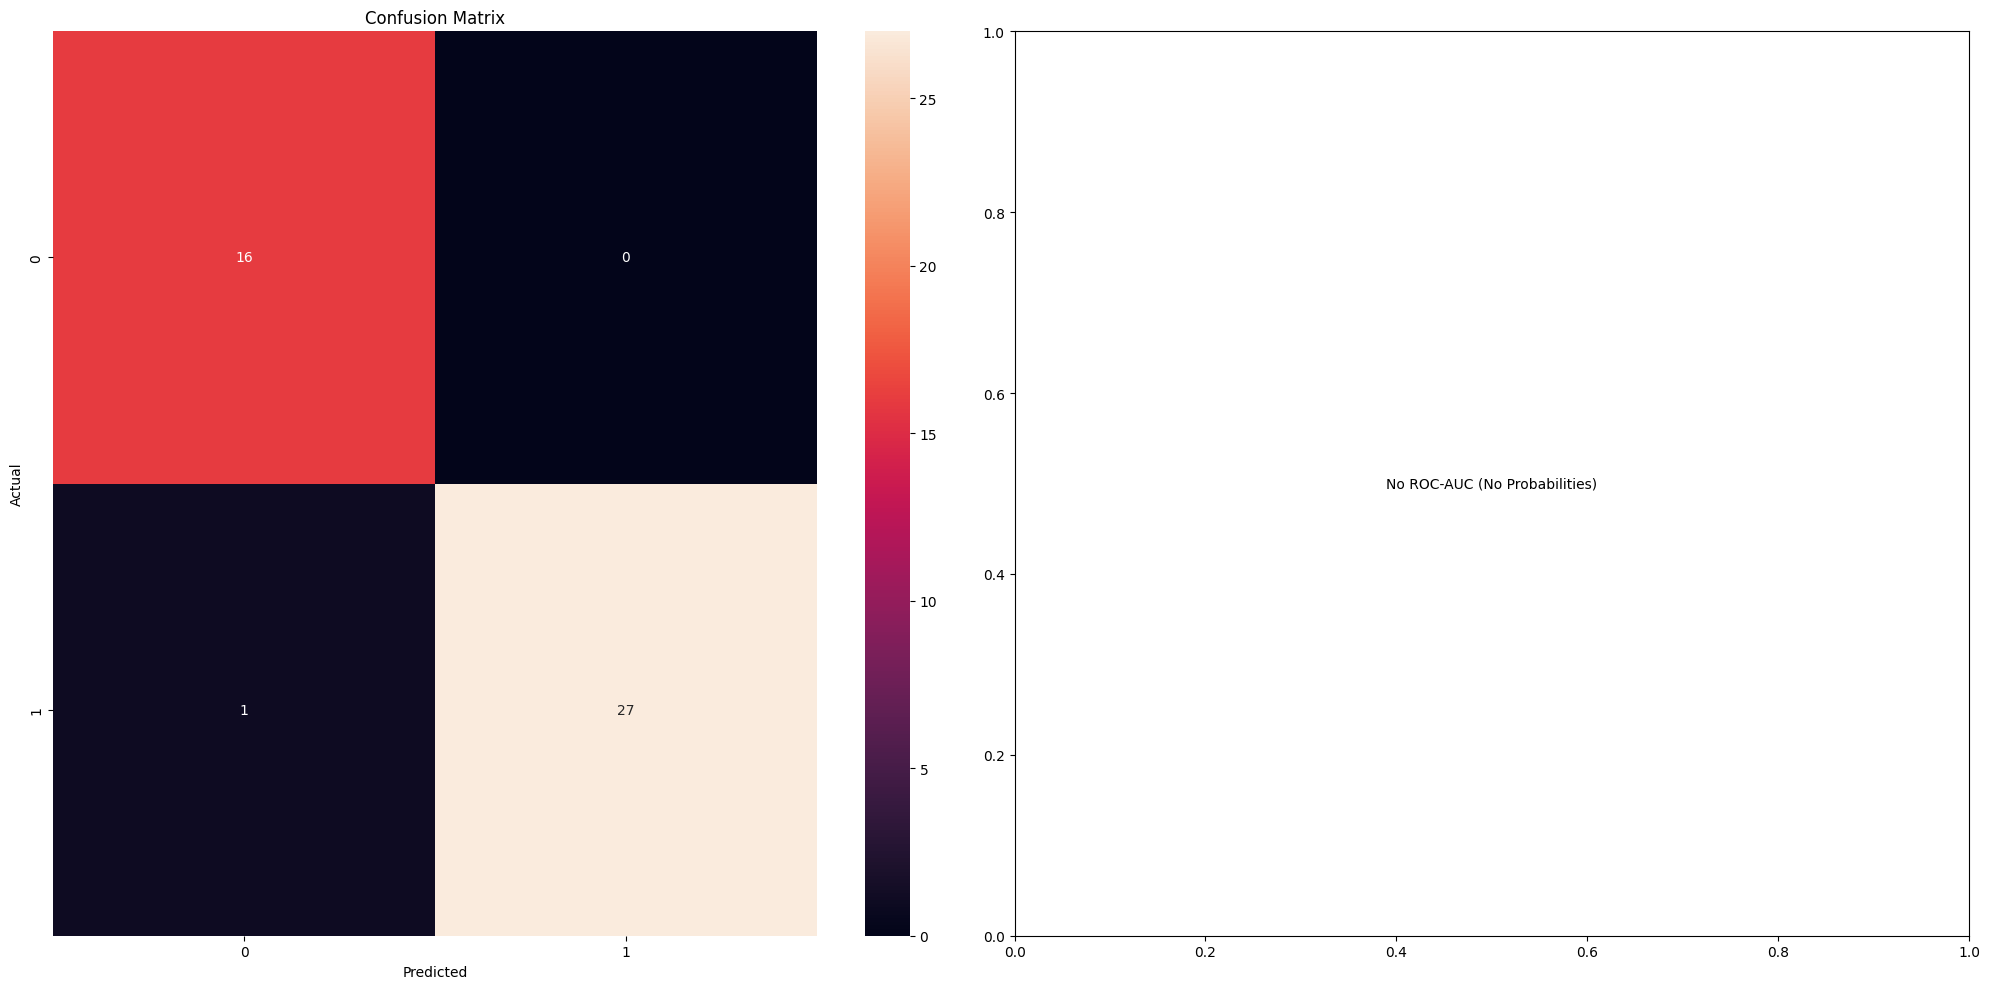

In [8]:
results_perceptron, scaler = classifier_selecting.optimize_classifier(X_train, X_test, y_train, y_test, 'perceptron')

print("\nBest Parameters:", results_perceptron['best_parameters'])
print("\nBest Cross-validation Score:", results_perceptron['best_score'])
print("\nFeature Importances:", results_perceptron['feature_importances'])
print("\nClassification Report:")
print(classification_report(y_test, results_perceptron['best_model'].predict(
    scaler.fit_transform(X_test))))

In [9]:
perceptron = Perceptron(**results_perceptron['best_parameters'])

sbs_perceptron = SequentialBackwardSelection(estimator=perceptron,
                                             min_features = 3,
                                             scoring_metric=accuracy_score,
                                             scale_features=True,
                                             verbose=True)
sbs_perceptron.fit(X_train, X_test, y_train, y_test)


Removed feature: Culmen Depth (mm)
Current performance: 1.0
Remaining features: ['Culmen Length (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Flipper Length (mm)
Current performance: 1.0
Remaining features: ['Culmen Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Delta 15 N (o/oo)
Current performance: 1.0
Remaining features: ['Culmen Length (mm)', 'Body Mass (g)', 'Delta 13 C (o/oo)']



n_jobs = -1
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': True}

Best Cross-validation Score: 0.9836666666666666

Feature Importances: {'Culmen Length (mm)': 0.4114976670780121, 'Culmen Depth (mm)': 0.030525131239902557, 'Flipper Length (mm)': 0.05618726961794439, 'Body Mass (g)': 0.03533731879438214, 'Delta 15 N (o/oo)': 0.08585889462272732, 'Delta 13 C (o/oo)': 0.3805937186470314}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        28

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



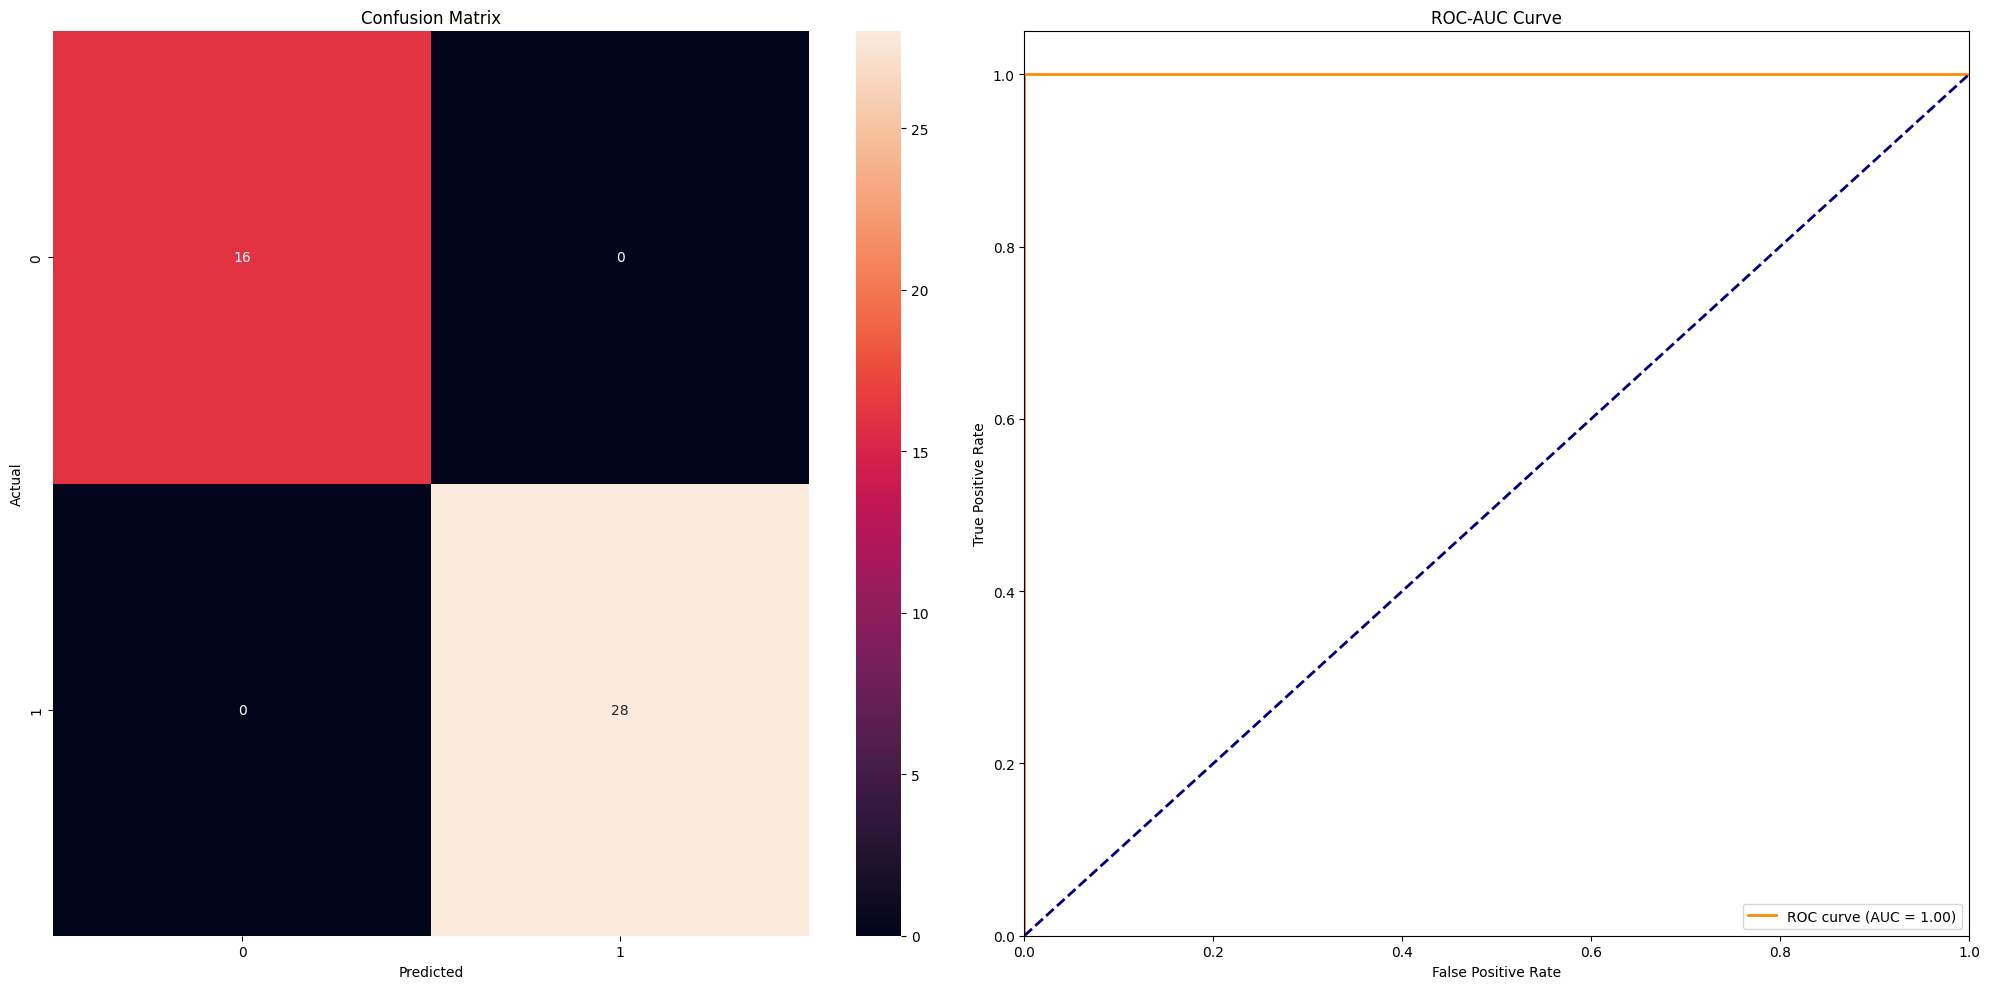

In [10]:
results_rf, scaler = classifier_selecting.optimize_classifier(X_train, X_test, y_train, y_test, 'rf')

print("\nBest Parameters:", results_rf['best_parameters'])
print("\nBest Cross-validation Score:", results_rf['best_score'])
print("\nFeature Importances:", results_rf['feature_importances'])
print("\nClassification Report:")
print(classification_report(y_test, results_rf['best_model'].predict(
    scaler.fit_transform(X_test))))

In [11]:
rf = RandomForestClassifier(**results_rf['best_parameters'])

sbs_rf = SequentialBackwardSelection(estimator=rf,
                                     min_features = 3,
                                     scoring_metric=accuracy_score,
                                     scale_features=True,
                                     verbose=True)
sbs_rf.fit(X_train, X_test, y_train, y_test)


Removed feature: Culmen Depth (mm)
Current performance: 1.0
Remaining features: ['Culmen Length (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Flipper Length (mm)
Current performance: 1.0
Remaining features: ['Culmen Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Body Mass (g)
Current performance: 1.0
Remaining features: ['Culmen Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']



n_jobs = -1
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Parameters: {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.05, 'max_features': None, 'max_depth': 40, 'criterion': 'entropy', 'class_weight': 'balanced'}

Best Cross-validation Score: 0.9797450980392156

Feature Importances: {'Culmen Length (mm)': 0.1842873439320089, 'Culmen Depth (mm)': 0.0, 'Flipper Length (mm)': 0.0, 'Body Mass (g)': 0.0, 'Delta 15 N (o/oo)': 0.0, 'Delta 13 C (o/oo)': 0.8157126560679911}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        28

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



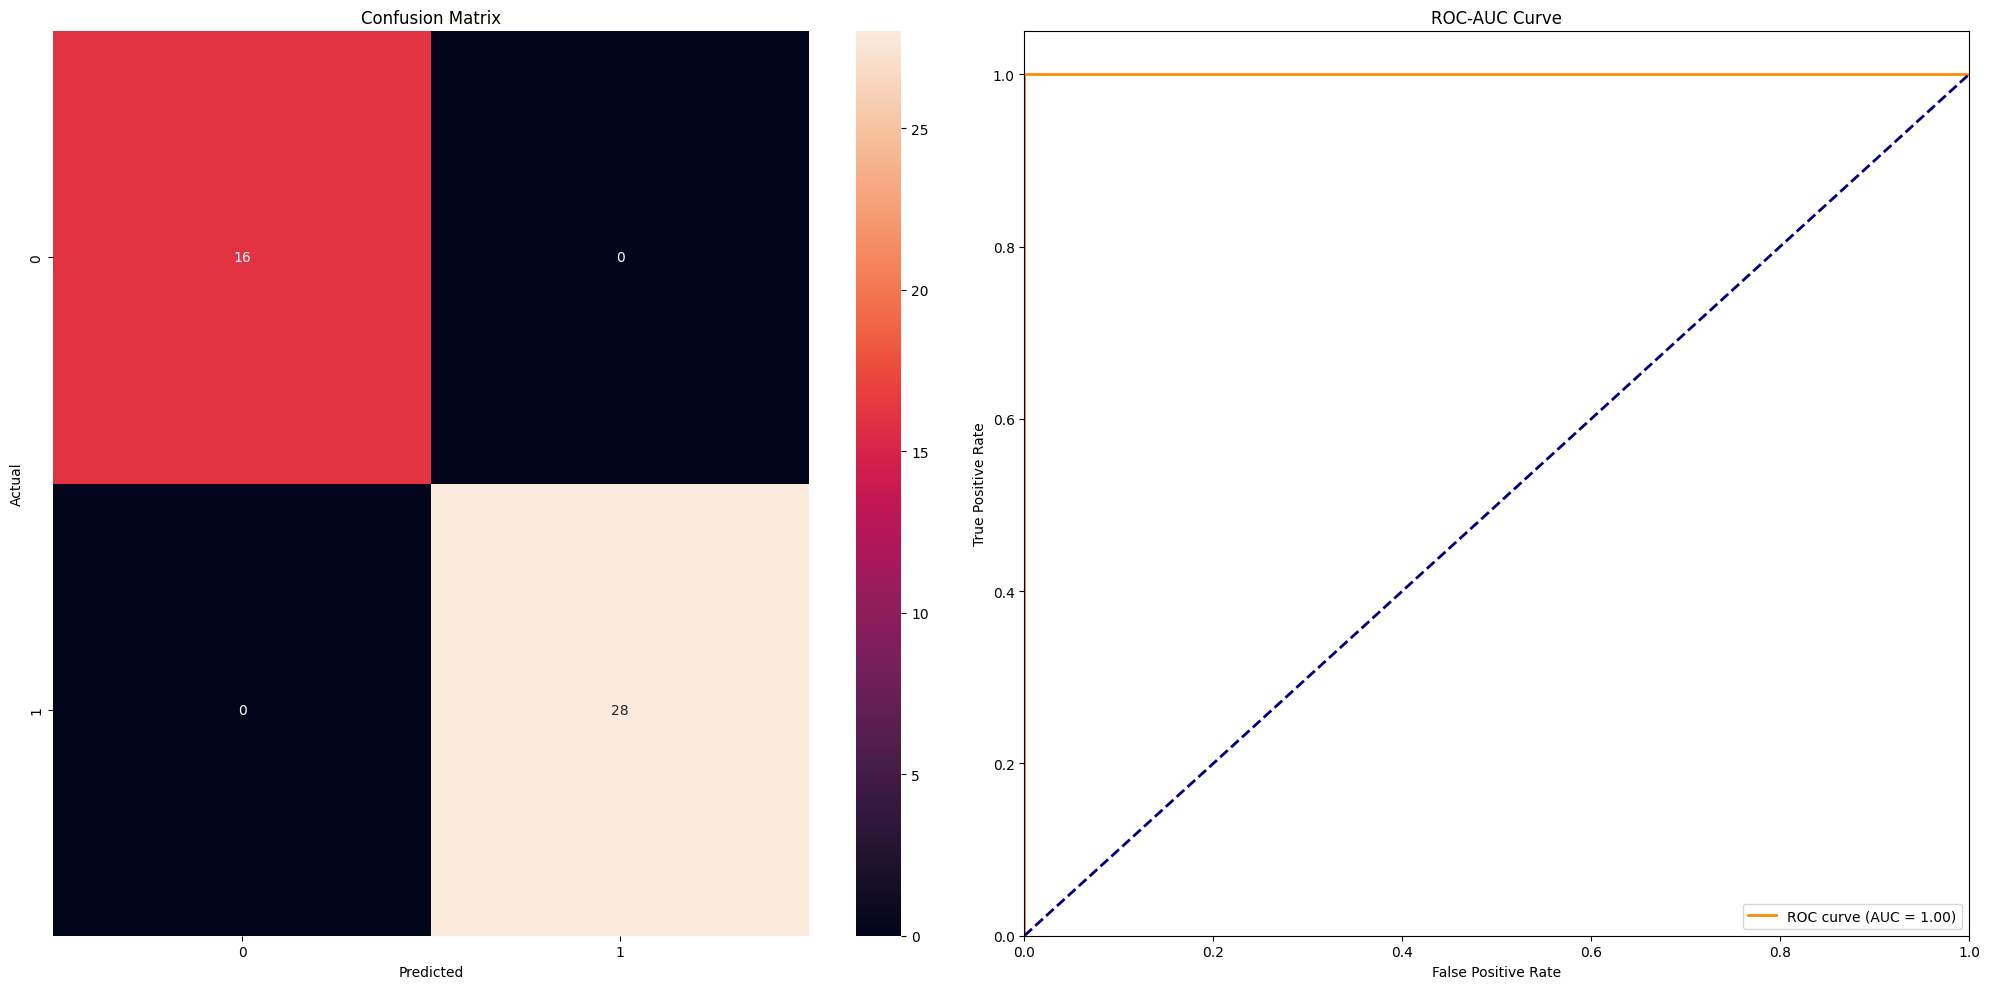

In [12]:
results_dt, scaler = classifier_selecting.optimize_classifier(X_train, X_test, y_train, y_test, 'dt')

print("\nBest Parameters:", results_dt['best_parameters'])
print("\nBest Cross-validation Score:", results_dt['best_score'])
print("\nFeature Importances:", results_dt['feature_importances'])
print("\nClassification Report:")
print(classification_report(y_test, results_dt['best_model'].predict(
    scaler.fit_transform(X_test))))

In [13]:
dt = DecisionTreeClassifier(**results_dt['best_parameters'])

sbs_dt = SequentialBackwardSelection(estimator=dt,
                                     min_features = 3,
                                     scoring_metric=accuracy_score,
                                     scale_features=True,
                                     verbose=True)
sbs_dt.fit(X_train, X_test, y_train, y_test)


Removed feature: Culmen Depth (mm)
Current performance: 1.0
Remaining features: ['Culmen Length (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Flipper Length (mm)
Current performance: 1.0
Remaining features: ['Culmen Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Body Mass (g)
Current performance: 1.0
Remaining features: ['Culmen Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']



n_jobs = -1
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Parameters: {'kernel': 'linear', 'gamma': 0.01, 'degree': 2, 'coef0': 0.5, 'class_weight': 'balanced', 'C': 10}

Best Cross-validation Score: 1.0

Feature Importances: {'Culmen Length (mm)': 3.5251464348894888, 'Culmen Depth (mm)': 0.9726930150191779, 'Flipper Length (mm)': 0.29256094565570434, 'Body Mass (g)': 0.5215934061895706, 'Delta 15 N (o/oo)': 0.4115541226760907, 'Delta 13 C (o/oo)': 1.578599146661602}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        28

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



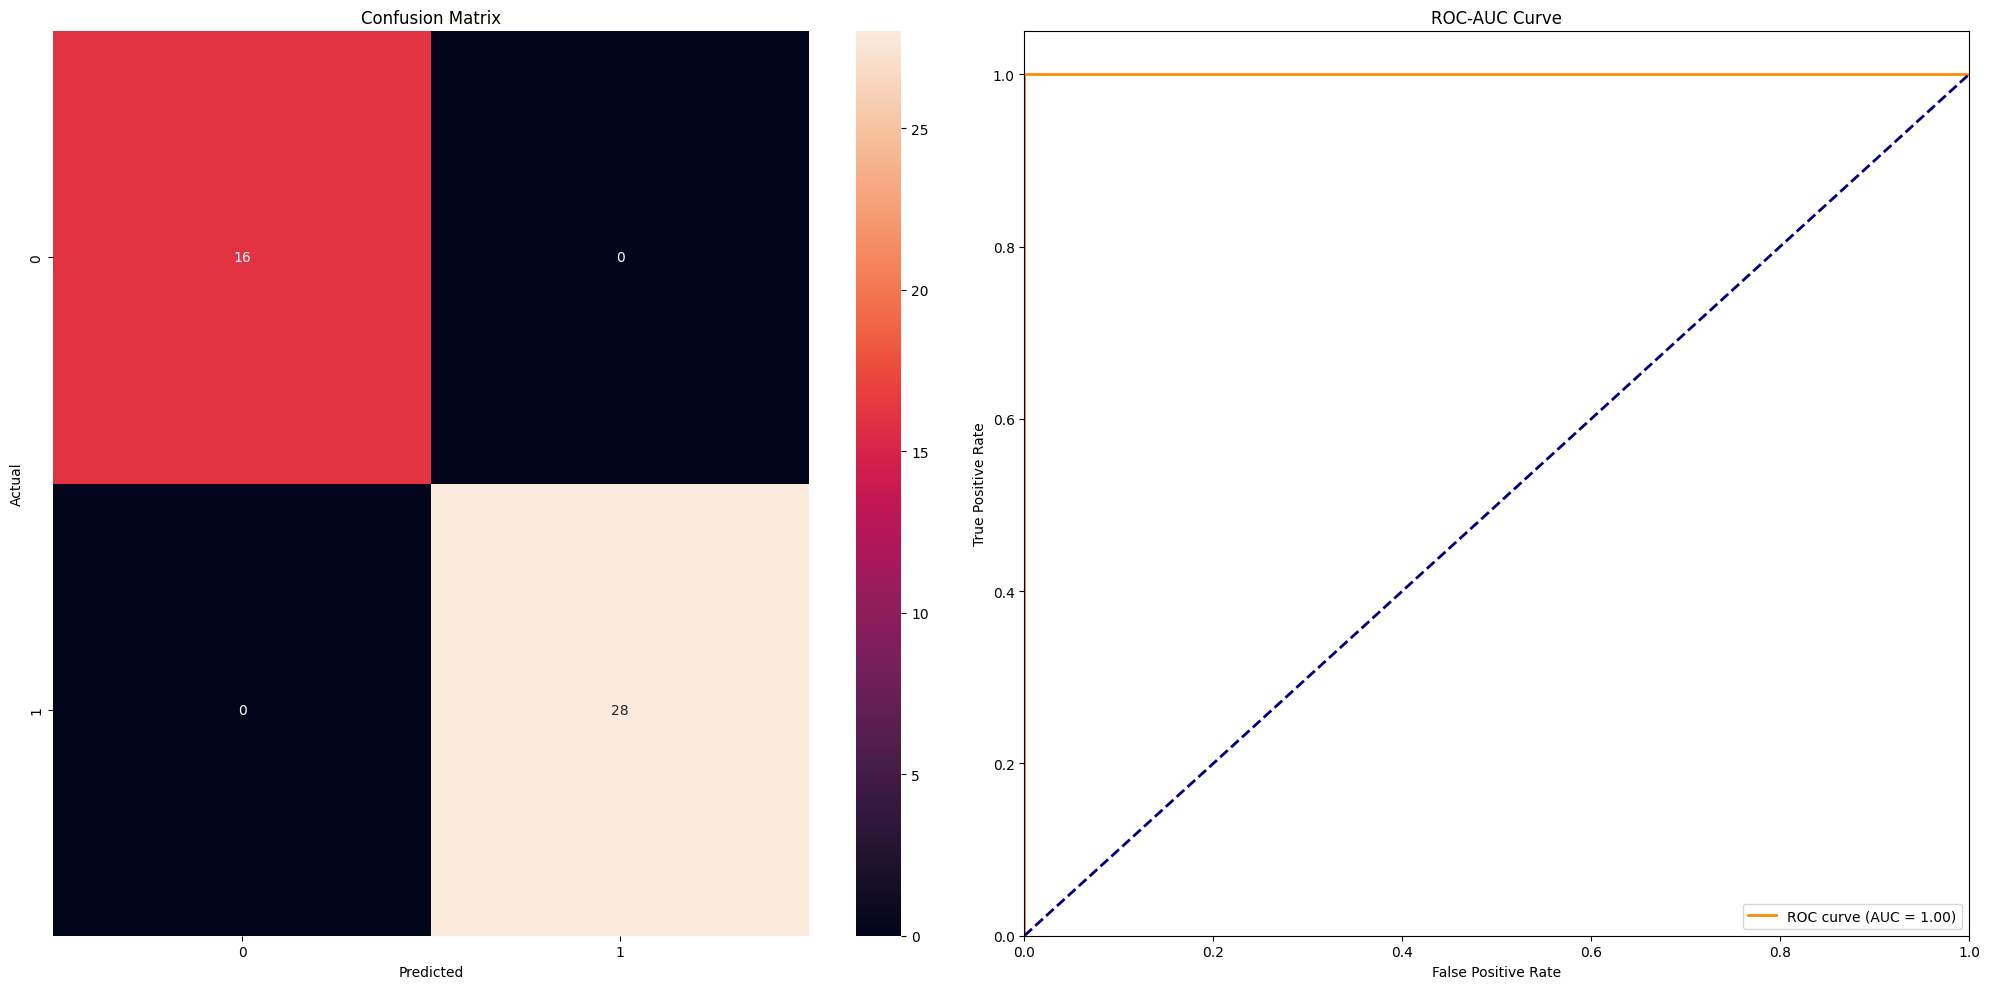

In [14]:
results_svm, scaler = classifier_selecting.optimize_classifier(X_train, X_test, y_train, y_test, 'svm')

print("\nBest Parameters:", results_svm['best_parameters'])
print("\nBest Cross-validation Score:", results_svm['best_score'])
print("\nFeature Importances:", results_svm['feature_importances'])
print("\nClassification Report:")
print(classification_report(y_test, results_svm['best_model'].predict(
    scaler.fit_transform(X_test))))

In [15]:
svm = SVC(**results_svm['best_parameters'])

sbs_svm = SequentialBackwardSelection(estimator=svm,
                                      min_features = 3,
                                      scoring_metric=accuracy_score,
                                      scale_features=True,
                                      verbose=True)
sbs_svm.fit(X_train, X_test, y_train, y_test)


Removed feature: Culmen Depth (mm)
Current performance: 1.0
Remaining features: ['Culmen Length (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Flipper Length (mm)
Current performance: 1.0
Remaining features: ['Culmen Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Delta 15 N (o/oo)
Current performance: 1.0
Remaining features: ['Culmen Length (mm)', 'Body Mass (g)', 'Delta 13 C (o/oo)']



In [16]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [17]:
def reorder_least_correlated_feature(X, standardize=True, feature_order=None, scaler=None):
    """
    Reorder X based on correlation or a provided feature order.

    Parameters:
    - X: numpy array or pandas DataFrame
    - standardize: bool
    - feature_order: list, optional order from training set (default: None, compute from X)
    - scaler: fitted scaler object (default: None, create new scaler if needed)

    Returns:
    - X_reordered, feature_order (if computed), scaler (if created/used)
    """
    is_dataframe = isinstance(X, pd.DataFrame)
    if is_dataframe:
        column_names = X.columns
        X_np = X.to_numpy()
    else:
        X_np = np.asarray(X)

    # Handle scaling regardless of whether feature_order is provided
    if standardize:
        if scaler is None:
            scaler = MinMaxScaler(feature_range=(-100,100))
            X_scaled = scaler.fit_transform(X_np)
        else:
            X_scaled = scaler.transform(X_np)
    else:
        X_scaled = X_np.copy()
        scaler = None

    # Compute feature order if not provided
    if feature_order is None:
        corr_matrix = np.abs(np.corrcoef(X_scaled, rowvar=False))
        n_features = X_np.shape[1]
        avg_corr = (np.sum(corr_matrix, axis=1) - np.diag(corr_matrix)) / (n_features - 1)
        target_idx = np.argmin(avg_corr)
        feature_order = list(range(n_features))
        feature_order.pop(target_idx)
        feature_order.append(target_idx)

    # Reorder the data (using original data, not scaled)
    if is_dataframe:
        X_reordered = X.iloc[:, feature_order]
    else:
        X_reordered = X_np[:, feature_order]

    return X_reordered, feature_order, scaler

# Usage:
X_train_reordered, feature_order, scaler = reorder_least_correlated_feature(X_train)
X_test_reordered, _, _ = reorder_least_correlated_feature(X_test, feature_order=feature_order, scaler=scaler)

In [18]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 100  # Increase animation size limit

class ImprovedSMPA(BaseEstimator, ClassifierMixin):
    """
    Smooth Manifold Projection Algorithm with improved boundary handling.
    This classifier uses a smooth spline boundary to separate binary classes in 2D.
    """

    def __init__(self, learning_rate=0.005, epochs=50, random_state=7, verbose=False,
                 lambda_scaling='log', patience=5, decay_factor=0.5, min_learning_rate=1e-6,
                 n_control_points=5, smoothing_factor=0.1, spline_type='cubic'):
        """
        Initialize the SMPA classifier.

        Parameters:
        -----------
        learning_rate : float, default=0.005
            Initial learning rate for gradient updates
        epochs : int, default=50
            Maximum number of training epochs
        random_state : int, default=7
            Random seed for reproducibility
        verbose : bool, default=False
            Whether to print progress during training
        lambda_scaling : {'log', 'sqrt', 'none'}, default='log'
            Method to scale the update based on distance
        patience : int, default=5
            Epochs to wait before reducing learning rate
        decay_factor : float, default=0.5
            Factor to reduce learning rate by when patience is exceeded
        min_learning_rate : float, default=1e-6
            Minimum learning rate to stop training
        n_control_points : int, default=5
            Number of control points for the spline
        smoothing_factor : float, default=0.1
            Smoothing parameter for the spline
        spline_type : {'cubic', 'pchip'}, default='cubic'
            Type of spline to use ('pchip' preserves monotonicity better)
        """
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_scaling = lambda_scaling
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type

        # Validation
        if lambda_scaling not in ['log', 'sqrt', 'none']:
            raise ValueError("lambda_scaling must be one of 'log', 'sqrt', or 'none'")
        if spline_type not in ['cubic', 'pchip']:
            raise ValueError("spline_type must be one of 'cubic' or 'pchip'")

        # History tracking
        self.error_history_ = []
        self.learning_rate_history_ = []
        self.control_point_history = []
        self.displacement_history = []
        self.error_index_history = []

        # Set random seed
        np.random.seed(random_state)

    def _calculate_class_means(self, X, y):
        """Calculate the mean point for each class."""
        mask_1 = y == 1
        self.m1 = X[mask_1].mean(axis=0)
        self.m0 = X[~mask_1].mean(axis=0)

    def _initialize_control_points(self, X):
        """Initialize control points with improved boundary handling."""
        # Data range with padding to prevent boundary issues
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        x_range = x_max - x_min
        y_range = y_max - y_min

        # Add padding outside data range for better boundary behavior
        x_min_extended = x_min - 0.2 * x_range
        x_max_extended = x_max + 0.2 * x_range

        # Create evenly spaced control points
        self.control_x = np.linspace(x_min_extended, x_max_extended, self.n_control_points)

        # Initialize control y values near the midpoint between class means
        y_mid = (self.m0[1] + self.m1[1]) / 2

        # Add slight randomization but keep endpoints stable
        self.control_y = np.random.uniform(
            y_mid - y_range * 0.05,
            y_mid + y_range * 0.05,
            self.n_control_points
        )

        # Make sure boundary control points have stable derivatives (flatter)
        # This helps prevent the spline from shooting up at the edges
        if self.n_control_points > 2:
            # Set the first and last control points to match second and second-to-last
            self.control_y[0] = self.control_y[1]
            self.control_y[-1] = self.control_y[-2]

        # Store initial control points for visualization
        self.initial_control_x = self.control_x.copy()
        self.initial_control_y = self.control_y.copy()
        self.control_point_history.append((self.control_x.copy(), self.control_y.copy()))

    def _fit_spline(self):
        """Fit a spline to the current control points with boundary constraints."""
        if self.spline_type == 'cubic':
            # Use cubic spline with clamped boundary conditions (zero derivative at endpoints)
            self.spline = CubicSpline(
                self.control_x,
                self.control_y,
                bc_type='clamped'  # This forces zero first derivative at endpoints
            )
        else:  # 'pchip'
            # PCHIP preserves monotonicity and reduces oscillations
            self.spline = PchipInterpolator(self.control_x, self.control_y)

    def _calculate_displacement(self, X):
        """Calculate vertical displacement from the spline."""
        spline_y = self.spline(X[:, 0])
        return X[:, 1] - spline_y

    def _update_pseudo_labels(self, X, y):
        """Determine which side of the spline each class should be on."""
        m1_displacement = self._calculate_displacement(self.m1.reshape(1, -1))[0]
        self.class_1_pseudo = 1 if m1_displacement > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return np.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def fit(self, X, y):
        """
        Fit the classifier to the training data.

        Parameters:
        -----------
        X : array-like, shape (n_samples, 2)
            Training data
        y : array-like, shape (n_samples,)
            Target values (0 or 1)

        Returns:
        --------
        self : object
            Returns self
        """
        # Validate inputs
        self.classes_ = np.unique(y)
        if not set(self.classes_).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] != 2:
            raise ValueError("This is a 2D-only algorithm for now!")

        X = np.asarray(X)
        y = np.asarray(y)

        # Reset training history
        self.control_point_history = []
        self.displacement_history = []
        self.error_index_history = []
        self.error_history_ = []
        self.learning_rate_history_ = []

        # Initialize
        self._calculate_class_means(X, y)
        self._initialize_control_points(X)
        self._fit_spline()

        # Track best model
        best_error = float('inf')
        best_control_x = None
        best_control_y = None
        best_class_1_pseudo = None

        # Learning rate scheduling
        patience_counter = 0
        current_learning_rate = self.initial_learning_rate

        # Pre-compute class indices for efficient updates
        indices_class_0 = np.where(y == 0)[0]
        indices_class_1 = np.where(y == 1)[0]

        # Main training loop
        for epoch in range(self.epochs):
            # Update spline and calculate errors
            self._fit_spline()
            pseudo_labels = self._update_pseudo_labels(X, y)
            displacements = self._calculate_displacement(X)
            errors = (displacements * pseudo_labels <= 0)
            error_count = np.sum(errors)

            # Store history
            self.error_history_.append(error_count)
            self.learning_rate_history_.append(current_learning_rate)
            self.displacement_history.append(displacements.copy())
            self.error_index_history.append(np.where(errors)[0].copy())

            # Verbose logging
            if self.verbose and epoch % 5 == 0:
                print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_learning_rate:.6f}")

            # Update best model if improved
            if error_count < best_error:
                best_error = error_count
                best_control_x = self.control_x.copy()
                best_control_y = self.control_y.copy()
                best_class_1_pseudo = self.class_1_pseudo
                patience_counter = 0
                self.best_epoch = epoch
            else:
                # Learning rate decay
                patience_counter += 1
                if patience_counter >= self.patience:
                    current_learning_rate = max(current_learning_rate * self.decay_factor, self.min_learning_rate)
                    patience_counter = 0
                    if current_learning_rate == self.min_learning_rate:
                        if self.verbose:
                            print(f"Min learning rate reached at epoch {epoch}")
                        break

            # Update control points based on errors
            if errors.any():
                error_indices = np.where(errors)[0]

                for idx in error_indices:
                    # Get the misclassified point
                    d = X[idx]

                    # Find nearest control point
                    distances = np.abs(self.control_x - d[0])
                    nearest_idx = np.argmin(distances)
                    distance = distances[nearest_idx]

                    # Scale update based on distance
                    if self.lambda_scaling == 'log':
                        lmbda = np.log1p(distance)
                    elif self.lambda_scaling == 'sqrt':
                        lmbda = np.sqrt(distance)
                    else:  # 'none'
                        lmbda = distance

                    # Adaptive margin: higher margins for points far from the decision boundary
                    margin = max(0.1, min(1.0, lmbda * 0.2))

                    # Determine opposite class's correctly classified points
                    if y[idx] == 1:  # Misclassified class 1 point
                        opp_indices = indices_class_0
                    else:  # Misclassified class 0 point
                        opp_indices = indices_class_1

                    # Find correctly classified points in opposite class
                    opp_displacements = displacements[opp_indices]
                    opp_labels = pseudo_labels[opp_indices]
                    correct_opp = opp_indices[opp_displacements * opp_labels > margin]  # Use margin

                    # Calculate step direction
                    if len(correct_opp) > 0:
                        # Pick a random subset of correctly classified opposite class points
                        n_random = max(1, min(len(correct_opp) // 5, 5))  # Take 20%, max 5 points
                        random_correct = np.random.choice(correct_opp, size=n_random, replace=False)

                        # Average position of the random subset
                        random_avg_opp = np.mean(X[random_correct], axis=0)

                        # Calculate step direction toward this average
                        delta_x = random_avg_opp[0] - self.control_x[nearest_idx]
                        delta_y = random_avg_opp[1] - self.control_y[nearest_idx]

                        # Apply step with learning rate
                        step_x = delta_x * current_learning_rate / (1 + lmbda)
                        step_y = delta_y * current_learning_rate / (1 + lmbda)
                    else:
                        # Fallback: Move control point vertically to correct the error
                        step_x = 0
                        step_y = -pseudo_labels[idx] * margin * current_learning_rate

                    # Constrain step_x to maintain ascending order of control points
                    if nearest_idx > 0:
                        min_allowed_x = self.control_x[nearest_idx - 1] + 1e-6
                        max_step_left = self.control_x[nearest_idx] - min_allowed_x
                        step_x = max(step_x, -max_step_left)
                    if nearest_idx < len(self.control_x) - 1:
                        max_allowed_x = self.control_x[nearest_idx + 1] - 1e-6
                        max_step_right = max_allowed_x - self.control_x[nearest_idx]
                        step_x = min(step_x, max_step_right)

                    # Apply updates
                    self.control_x[nearest_idx] += step_x
                    self.control_y[nearest_idx] += step_y

                    # Special handling for boundary control points
                    # Keep first and last control points moving less to prevent boundary issues
                    if nearest_idx == 0 or nearest_idx == len(self.control_x) - 1:
                        # Scale down the step for boundary points
                        self.control_y[nearest_idx] *= 0.7  # Dampen movement at boundaries

                        # If it's the first control point, make second point match the derivative
                        if nearest_idx == 0 and len(self.control_x) > 2:
                            delta = self.control_y[1] - self.control_y[0]
                            self.control_y[0] = self.control_y[1] - 0.5 * delta

                        # If it's the last control point, make second-to-last point match the derivative
                        elif nearest_idx == len(self.control_x) - 1 and len(self.control_x) > 2:
                            delta = self.control_y[-1] - self.control_y[-2]
                            self.control_y[-1] = self.control_y[-2] + 0.5 * delta

            # Store control points after all updates
            self.control_point_history.append((self.control_x.copy(), self.control_y.copy()))

        # Store the last control points from the final epoch
        self.last_control_x = self.control_x.copy()
        self.last_control_y = self.control_y.copy()

        # Restore best model for prediction
        self.control_x = best_control_x
        self.control_y = best_control_y
        self._fit_spline()
        self.class_1_pseudo = best_class_1_pseudo

        return self

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters:
        -----------
        X : array-like, shape (n_samples, 2)
            The input samples

        Returns:
        --------
        y : array-like, shape (n_samples,)
            The predicted classes (0 or 1)
        """
        X = np.asarray(X)
        displacements = self._calculate_displacement(X)
        return np.where(displacements > 0,
                        1 if self.class_1_pseudo > 0 else 0,
                        0 if self.class_1_pseudo > 0 else 1)

    def predict_proba(self, X):
        """
        Estimate probability of each class for samples in X.

        Parameters:
        -----------
        X : array-like, shape (n_samples, 2)
            The input samples

        Returns:
        --------
        proba : array-like, shape (n_samples, 2)
            The class probabilities
        """
        X = np.asarray(X)
        displacements = self._calculate_displacement(X)

        # Convert displacements to probabilities with sigmoid
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        # Scale displacement to probability (use absolute displacement as confidence)
        raw_probs = sigmoid(displacements * self.class_1_pseudo * 0.5)

        # Create probability array [p(class=0), p(class=1)]
        if self.class_1_pseudo > 0:
            probs = np.column_stack([1 - raw_probs, raw_probs])
        else:
            probs = np.column_stack([raw_probs, 1 - raw_probs])

        return probs

    def plot_convergence(self, figsize=(12, 5)):
        """Plot error and learning rate history."""
        try:
            import matplotlib.pyplot as plt
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

            # Plot error history
            ax1.plot(self.error_history_, 'b-', label='Errors')
            ax1.set_title('Error Convergence')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Number of Errors')
            ax1.grid(True)

            # Mark the best epoch
            if hasattr(self, 'best_epoch'):
                ax1.axvline(x=self.best_epoch, color='g', linestyle='--',
                            label=f'Best (Epoch {self.best_epoch})')

            # Plot learning rate history
            ax2.plot(self.learning_rate_history_, 'r-', label='Learning Rate')
            ax2.set_title('Learning Rate Decay')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Learning Rate')
            ax2.set_yscale('log')
            ax2.grid(True)

            plt.tight_layout()
            fig.legend()
            return fig
        except ImportError:
            print("Install matplotlib with 'pip install matplotlib'!")
            return None

    def plot_boundary(self, X, y, figsize=(10, 8), padding_factor=0.1):
        """Plot decision boundary and training data."""
        try:
            import matplotlib.pyplot as plt
            import numpy as np
            fig = plt.figure(figsize=figsize)

            # Determine plot ranges
            x_min, x_max = X[:, 0].min(), X[:, 0].max()
            y_min, y_max = X[:, 1].min(), X[:, 1].max()
            x_range = x_max - x_min
            y_range = y_max - y_min

            # Add padding
            x_min -= x_range * padding_factor
            x_max += x_range * padding_factor
            y_min -= y_range * padding_factor
            y_max += y_range * padding_factor

            # Create x-range for spline evaluation
            x_range_points = np.linspace(x_min, x_max, 500)

            # Scatter plot of data points
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6, s=50, zorder=5)

            # Plot initial spline
            if hasattr(self, 'initial_control_x') and hasattr(self, 'initial_control_y'):
                if self.spline_type == 'cubic':
                    initial_spline = CubicSpline(self.initial_control_x, self.initial_control_y, bc_type='clamped')
                else:
                    initial_spline = PchipInterpolator(self.initial_control_x, self.initial_control_y)

                y_initial = initial_spline(x_range_points)
                plt.plot(x_range_points, y_initial, 'r--', label='Initial Boundary', alpha=0.7, zorder=1)

            # Plot best spline
            y_best = self.spline(x_range_points)
            plt.plot(x_range_points, y_best, 'g-', label='Best Boundary', linewidth=2, zorder=2)

            # Plot control points
            plt.scatter(self.initial_control_x, self.initial_control_y,
                        c='orange', marker='o', label='Initial Control Points', alpha=0.7, s=80, zorder=3)
            plt.scatter(self.control_x, self.control_y,
                        c='k', marker='x', label='Best Control Points', s=100, zorder=4)

            # Add class labels
            class0_idx = np.where(y == 0)[0]
            class1_idx = np.where(y == 1)[0]
            class0_center = np.mean(X[class0_idx], axis=0)
            class1_center = np.mean(X[class1_idx], axis=0)

            plt.annotate('Class 0', xy=(class0_center[0], class0_center[1]),
                        xytext=(class0_center[0] + x_range*0.05, class0_center[1] + y_range*0.05),
                        arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                        fontsize=12, fontweight='bold')

            plt.annotate('Class 1', xy=(class1_center[0], class1_center[1]),
                        xytext=(class1_center[0] - x_range*0.05, class1_center[1] - y_range*0.05),
                        arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                        fontsize=12, fontweight='bold')

            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.legend(loc='upper right')
            plt.title(f'ImprovedSMPA Decision Boundary ({self.spline_type} spline)')
            plt.grid(True, linestyle='--', alpha=0.3)

            return fig
        except ImportError:
            print("Install matplotlib with 'pip install matplotlib'!")
            return None

    def animate_training(self, X, y, interval=200, save_path=None,
                     every_nth_epoch=1, figsize=(10, 8), padding_factor=0.1):
        """
        Create an animation of the spline's evolution during training.

        Parameters:
        -----------
        X, y : Training data
        interval : Time between frames in milliseconds
        save_path : If provided, save the animation to this path
        every_nth_epoch : Only show every nth epoch (to reduce animation size)
        figsize : Figure size
        padding_factor : Factor to add padding around the data

        Returns:
        --------
        Animation object that can be displayed in Jupyter/Colab
        """
        try:
            import matplotlib.pyplot as plt
            import matplotlib.animation as animation
            from IPython.display import HTML

            if not self.control_point_history:
                print("No training history found. Run fit() first.")
                return None

            # Set up the figure and axis
            fig, ax = plt.subplots(figsize=figsize)

            # Prepare data ranges with appropriate padding
            x_min, x_max = X[:, 0].min(), X[:, 0].max()
            y_min, y_max = X[:, 1].min(), X[:, 1].max()
            x_range = x_max - x_min
            y_range = y_max - y_min

            x_min -= x_range * padding_factor
            x_max += x_range * padding_factor
            y_min -= y_range * padding_factor
            y_max += y_range * padding_factor

            # Create x-range for spline evaluation
            x_range_points = np.linspace(x_min, x_max, 200)

            # Scatter plot of the data (static)
            scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6, s=50, zorder=5)

            # Initialize spline line and control points that will be updated
            spline_line, = ax.plot([], [], 'g-', lw=2, zorder=2)
            control_points = ax.scatter([], [], c='k', marker='x', s=100, zorder=4)

            # Error points highlighting
            error_points = ax.scatter([], [], color='yellow', edgecolor='black',
                                    marker='*', s=150, alpha=0.7, zorder=6)

            # Text for epoch counter and error count
            info_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12,
                            bbox=dict(facecolor='white', alpha=0.7))

            # Set up plot limits and labels
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_title(f'ImprovedSMPA Training Evolution ({self.spline_type} spline)')
            ax.grid(True, linestyle='--', alpha=0.3)

            # Only use a subset of epochs to make the animation manageable
            epochs_to_show = list(range(0, len(self.control_point_history), every_nth_epoch))

            def init():
                spline_line.set_data([], [])
                control_points.set_offsets(np.empty((0, 2)))
                error_points.set_offsets(np.empty((0, 2)))
                info_text.set_text('')
                return spline_line, control_points, error_points, info_text

            def update(frame_idx):
                epoch = epochs_to_show[frame_idx] if frame_idx < len(epochs_to_show) else 0
                if epoch >= len(self.control_point_history):
                    return spline_line, control_points, error_points, info_text

                # Get control points and fit spline
                control_x, control_y = self.control_point_history[epoch]
                try:
                    if self.spline_type == 'cubic':
                        spline = CubicSpline(control_x, control_y, bc_type='clamped')
                    else:
                        spline = PchipInterpolator(control_x, control_y)

                    y_spline = spline(x_range_points)

                    # Handle extreme values
                    mask = np.isfinite(y_spline) & (np.abs(y_spline) < 1e6)
                    if not np.all(mask):
                        # Replace extreme values with something reasonable
                        y_spline = np.clip(y_spline, y_min, y_max)
                        y_spline[~mask] = np.nan  # NaN values won't be plotted

                    # Update spline line
                    spline_line.set_data(x_range_points, y_spline)

                    # Update control points
                    control_points.set_offsets(np.column_stack((control_x, control_y)))

                    # Update error points if we have them
                    if epoch < len(self.error_index_history):
                        error_indices = self.error_index_history[epoch]
                        if len(error_indices) > 0:
                            error_points.set_offsets(X[error_indices])
                        else:
                            error_points.set_offsets(np.empty((0, 2)))

                    # Update info text
                    error_count = self.error_history_[epoch] if epoch < len(self.error_history_) else "N/A"
                    if hasattr(self, 'best_epoch') and epoch == self.best_epoch:
                        info_text.set_text(f'Epoch: {epoch} | Errors: {error_count} | BEST MODEL')
                        info_text.set_bbox(dict(facecolor='lightgreen', alpha=0.7))
                    else:
                        info_text.set_text(f'Epoch: {epoch} | Errors: {error_count}')
                        info_text.set_bbox(dict(facecolor='white', alpha=0.7))
                except Exception as e:
                    print(f"Error in frame {frame_idx} (epoch {epoch}): {e}")
                    # Keep previous state in case of error

                return spline_line, control_points, error_points, info_text

            # Create the animation
            ani = animation.FuncAnimation(fig, update, frames=len(epochs_to_show),
                                        init_func=init, blit=True, interval=interval)

            # Save if requested
            if save_path:
                ani.save(save_path, writer='pillow', dpi=100)
                print(f"Animation saved to {save_path}")

            plt.close(fig)  # Close the figure to avoid displaying it twice
            return ani

        except ImportError as e:
            print(f"Error: {e}. Make sure you have matplotlib installed.")
            return None

In [19]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.interpolate import CubicSpline, PchipInterpolator

class NDSMPA(BaseEstimator, ClassifierMixin):
    """
    N-Dimensional Smooth Manifold Projection Algorithm.
    Extends ImprovedSMPA to n dimensions by fitting 2D models for each feature
    against a target feature and combining results additively.
    """

    def __init__(self, learning_rate=0.005, epochs=50, random_state=7, verbose=False,
                 lambda_scaling='log', patience=5, decay_factor=0.5, min_learning_rate=1e-6,
                 n_control_points=5, smoothing_factor=0.1, spline_type='cubic',
                 target_feature=-1, aggregation_method='displacement'):
        """
        Initialize the NDSMPA classifier.

        Parameters:
        -----------
        [Same as ImprovedSMPA parameters]
        target_feature : int, default=-1
            Index of the feature to use as the target dimension (-1 for last feature)
        aggregation_method : {'displacement', 'proba'}, default='displacement'
            Method to aggregate 2D model outputs ('displacement' sums signed displacements,
            'proba' averages probabilities)
        """
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_scaling = lambda_scaling
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type
        self.target_feature = target_feature
        self.aggregation_method = aggregation_method

        if aggregation_method not in ['displacement', 'proba']:
            raise ValueError("aggregation_method must be 'displacement' or 'proba'")

        np.random.seed(random_state)
        self.models_ = []  # List to store 2D SMPA models

    def fit(self, X, y):
        """
        Fit the classifier to n-dimensional data.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training data
        y : array-like, shape (n_samples,)
            Target values (0 or 1)

        Returns:
        --------
        self : object
        """
        X = np.asarray(X)
        y = np.asarray(y)
        n_features = X.shape[1]

        if n_features < 2:
            raise ValueError("Data must have at least 2 features")

        # Validate target_feature
        if self.target_feature >= n_features or self.target_feature < -n_features:
            raise ValueError(f"target_feature must be between {-n_features} and {n_features-1}")
        target_idx = self.target_feature if self.target_feature >= 0 else n_features + self.target_feature

        # Reset models
        self.models_ = []

        # Fit a 2D SMPA model for each feature (except target) paired with target feature
        for feature_idx in range(n_features):
            if feature_idx == target_idx:
                continue
            # Extract 2D subset: [current feature, target feature]
            X_2d = X[:, [feature_idx, target_idx]]

            # Initialize and fit 2D model
            model = ImprovedSMPA(
                learning_rate=self.learning_rate,
                epochs=self.epochs,
                random_state=self.random_state + feature_idx,  # Vary seed for diversity
                verbose=self.verbose,
                lambda_scaling=self.lambda_scaling,
                patience=self.patience,
                decay_factor=self.decay_factor,
                min_learning_rate=self.min_learning_rate,
                n_control_points=self.n_control_points,
                smoothing_factor=self.smoothing_factor,
                spline_type=self.spline_type
            )
            model.fit(X_2d, y)
            self.models_.append(model)

        self.n_features_ = n_features
        self.target_idx_ = target_idx
        return self

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            The input samples

        Returns:
        --------
        y : array-like, shape (n_samples,)
            The predicted classes (0 or 1)
        """
        X = np.asarray(X)
        if X.shape[1] != self.n_features_:
            raise ValueError(f"Expected {self.n_features_} features, got {X.shape[1]}")

        if self.aggregation_method == 'displacement':
            # Sum signed displacements across all models
            total_displacement = np.zeros(X.shape[0])
            for idx, model in enumerate(self.models_):
                feature_idx = idx if idx < self.target_idx_ else idx + 1  # Adjust for skipped target
                X_2d = X[:, [feature_idx, self.target_idx_]]
                displacements = model._calculate_displacement(X_2d) * model.class_1_pseudo
                total_displacement += displacements
            # Positive total displacement -> class 1, negative -> class 0
            return np.where(total_displacement > 0, 1, 0)
        else:  # 'proba'
            # Average probabilities across all models
            proba = self.predict_proba(X)
            return np.argmax(proba, axis=1)

    def predict_proba(self, X):
        """
        Estimate probability of each class for samples in X.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            The input samples

        Returns:
        --------
        proba : array-like, shape (n_samples, 2)
            The class probabilities
        """
        X = np.asarray(X)
        if X.shape[1] != self.n_features_:
            raise ValueError(f"Expected {self.n_features_} features, got {X.shape[1]}")

        # Collect probabilities from all models
        probas = []
        for idx, model in enumerate(self.models_):
            feature_idx = idx if idx < self.target_idx_ else idx + 1
            X_2d = X[:, [feature_idx, self.target_idx_]]
            proba = model.predict_proba(X_2d)
            probas.append(proba)

        # Average probabilities
        mean_proba = np.mean(np.stack(probas, axis=0), axis=0)
        return mean_proba

In [20]:
param_grid = {
    'learning_rate': [0.001, 0.005, 0.01],           # Learning rate options
    'epochs': [20, 50, 100],                         # Number of epochs
    'n_control_points': [3, 5, 7],                   # Number of spline control points
    'smoothing_factor': [0.05, 0.1, 0.2],            # Smoothing factor for spline
    'aggregation_method': ['displacement', 'proba']  # Aggregation methods
}

# Initialize the base model
base_model = NDSMPA(random_state=7, verbose=False)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Optimize for accuracy
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)
grid_search.fit(X_train_reordered, y_train)

# Results
print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set with best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_reordered)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy with best model: {test_accuracy:.4f}")

print("Classification report: \n")
cr = classification_report(y_test, y_pred)
print(cr)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


/tmp/ipykernel_77138/2097424821.py:374: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_77138/2097424821.py:374: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_77138/2097424821.py:374: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_77138/2097424821.py:374: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_77138/2097424821.py:374: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_77138/2097424821.py:374: RuntimeWarning: overflow encountered in exp



Best parameters found:
{'aggregation_method': 'displacement', 'epochs': 100, 'learning_rate': 0.01, 'n_control_points': 7, 'smoothing_factor': 0.05}
Best cross-validation accuracy: 0.8632
Test set accuracy with best model: 0.9318
Classification report: 

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.89      0.94        28

    accuracy                           0.93        44
   macro avg       0.92      0.95      0.93        44
weighted avg       0.94      0.93      0.93        44

